# Bit-plane Slicing

In [1]:
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import img_as_float
%matplotlib inline

In [2]:
read = Image.open('100ribu-rupiah.jpg').convert('L')
image = np.asarray(read)
image.shape
plt.imsave('100ribu.png', image, format='png', cmap='gray')

In [3]:
image = np.reshape(image,(-1,1200,1))
bitplane = np.unpackbits(image, axis=2)
bitplane.shape

plt.imsave('bit8.png', bitplane[:,:,0], format='png', cmap='gray')

<table>
    <caption><h1>Bit-Plane</h1></caption>
  <tr>
    <td><img src="100ribu.png" width="250"></td>
    <td><img src="bit1.png" width="250"></td>
    <td><img src="bit2.png" width="250"></td>  
  </tr>
  <tr>
    <td><img src="bit3.png" width="250"></td>
    <td><img src="bit4.png" width="250"></td>
    <td><img src="bit5.png" width="250"></td>  
  </tr>
  <tr>
    <td><img src="bit6.png" width="250"></td>
    <td><img src="bit7.png" width="250"></td>
    <td><img src="bit8.png" width="250"></td>  
  </tr>  
</table>

In [4]:
bit = 2**7*bitplane[:,:,0] + 2**6*bitplane[:,:,1] + 2**5*bitplane[:,:,2] 
2**5*bitplane[:,:,2]

array([[32, 32, 32, ..., 32, 32, 32],
       [ 0,  0,  0, ...,  0,  0,  0],
       [32, 32, 32, ..., 32, 32, 32],
       ...,
       [32, 32,  0, ..., 32, 32, 32],
       [32, 32, 32, ..., 32, 32, 32],
       [32, 32, 32, ..., 32, 32, 32]], dtype=uint8)

In [5]:
plt.imsave('bit_compress.png', bit, format='png', cmap='gray')

<table>
    <caption><h1>Image compression dengan bit-plane slicing</h1></caption>
  <tr>
    <td>Original</td>
    <td>Image compressed</td>  
  </tr>
  <tr>
    <td><img src="100ribu.png" width="250"></td>
    <td><img src="bit_compress.png" width="250"></td>  
</table>

In [6]:
import os
print(os.stat('bit_compress.png').st_size)
print(os.stat('100ribu.png').st_size)

340135
1165585


# Histogram Processing

In [7]:
read = Image.open('Fig0840_0021.tif').convert('L')

In [8]:
img = np.asarray(read)

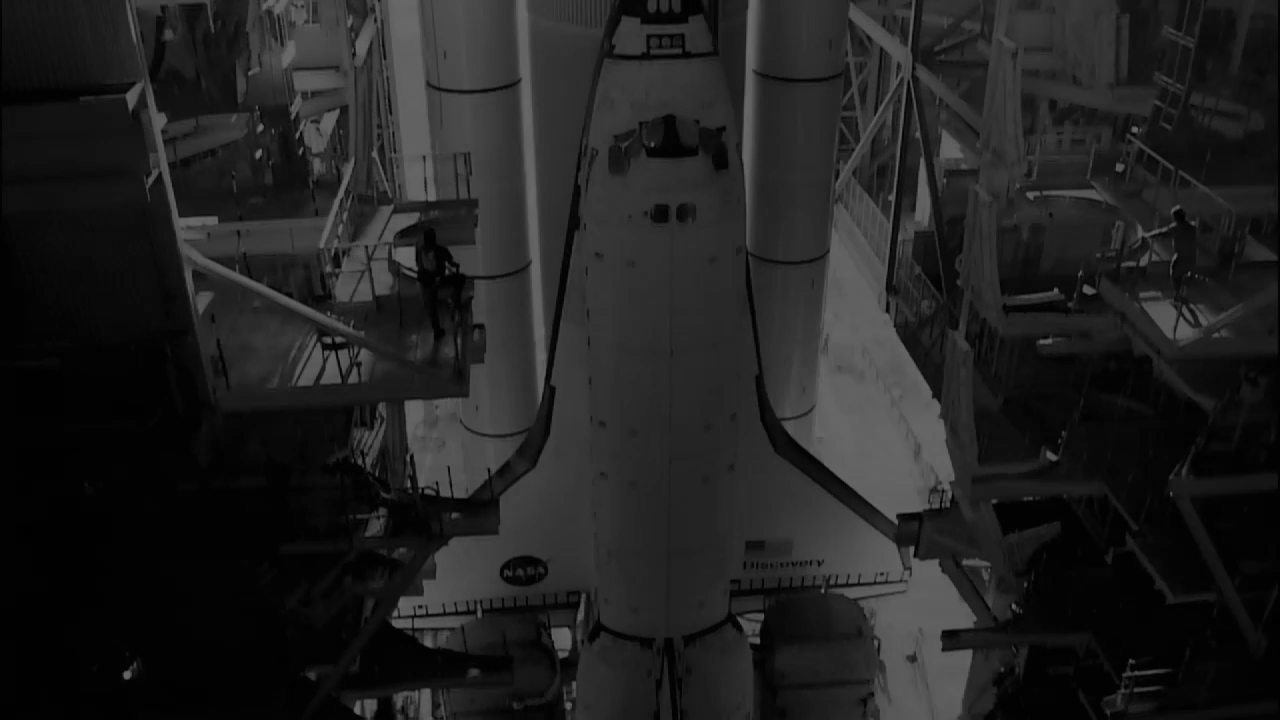

In [9]:
read

In [10]:
img

array([[ 4,  9, 18, ..., 25,  8,  6],
       [ 4,  9, 18, ..., 25,  8,  6],
       [ 4,  8, 18, ..., 25,  8,  6],
       ...,
       [ 1,  1,  1, ...,  3,  3,  3],
       [ 1,  1,  1, ...,  3,  3,  3],
       [ 1,  1,  1, ...,  3,  3,  3]], dtype=uint8)

In [11]:
img.shape

(720, 1280)

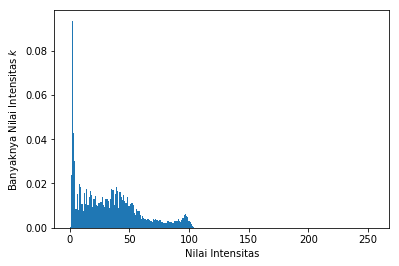

In [12]:
plt.xlabel('Nilai Intensitas')
plt.ylabel('Banyaknya Nilai Intensitas $k$')
plt.hist(img.ravel(), bins=256, range=(0,255), density=True);

In [13]:
img.max(), img.min()
contrast_stretching = exposure.rescale_intensity(img, in_range=(img.min(), img.max()))
contrast_stretching

array([[ 9, 21, 42, ..., 59, 18, 14],
       [ 9, 21, 42, ..., 59, 18, 14],
       [ 9, 18, 42, ..., 59, 18, 14],
       ...,
       [ 2,  2,  2, ...,  7,  7,  7],
       [ 2,  2,  2, ...,  7,  7,  7],
       [ 2,  2,  2, ...,  7,  7,  7]], dtype=uint8)

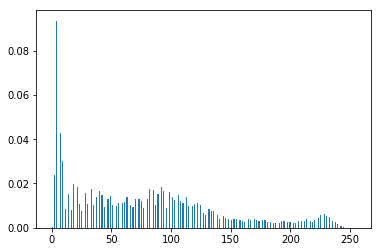

In [14]:
plt.hist(contrast_stretching.ravel(), bins=256, range=(0,255), density=True);

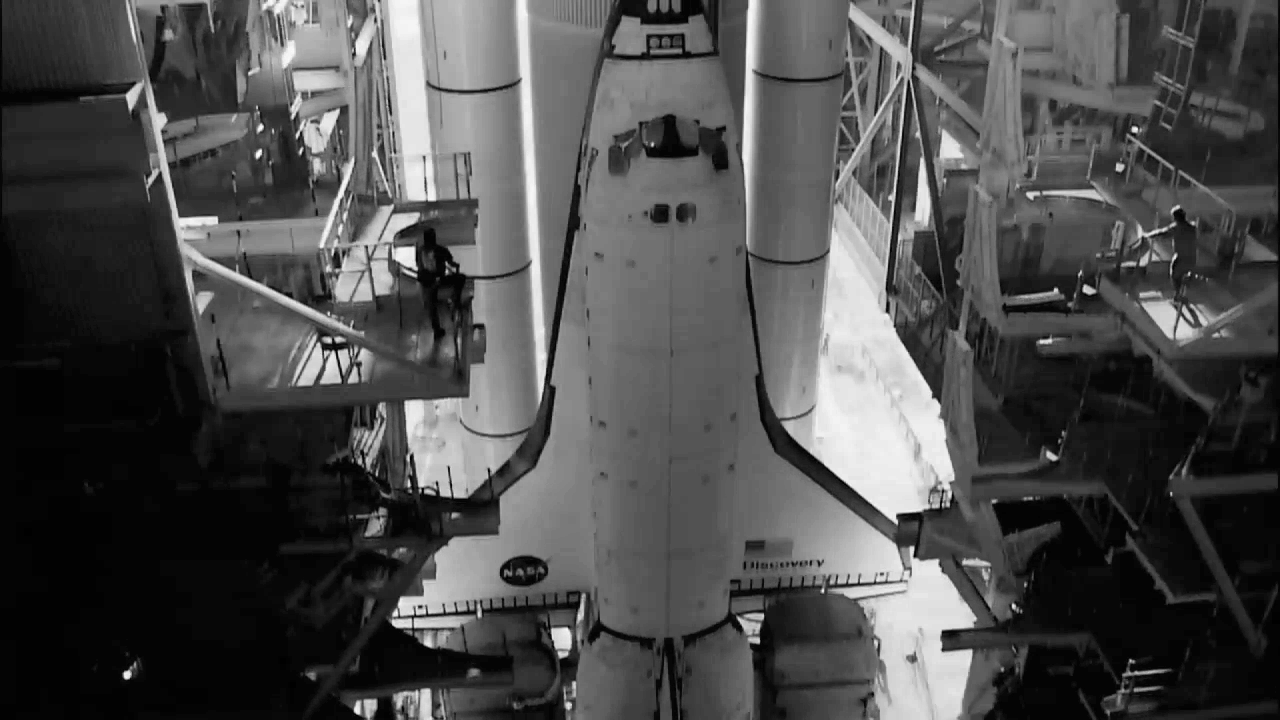

In [15]:
contrast_img = Image.fromarray(contrast_stretching)
contrast_img

In [16]:
def df(img):  # make a histogram
    values = [0]*256
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            values[img[i,j]]+=1
    return values


def cdf(hist):  # cumulative distribution frequency
    cdf = [0] * len(hist)   
    cdf[0] = hist[0]
    for i in range(1, len(hist)):
        cdf[i]= cdf[i-1]+hist[i]
    # Normalize the histogram
    cdf = [ele*255/cdf[-1] for ele in cdf] 
    return cdf

def equalize_image(image):
    my_cdf = cdf(df(img))
    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image, range(0,256), my_cdf)
    return image_equalized

eq = equalize_image(img)
eq_int = eq.astype('uint8')
img_eq = Image.fromarray(eq_int)

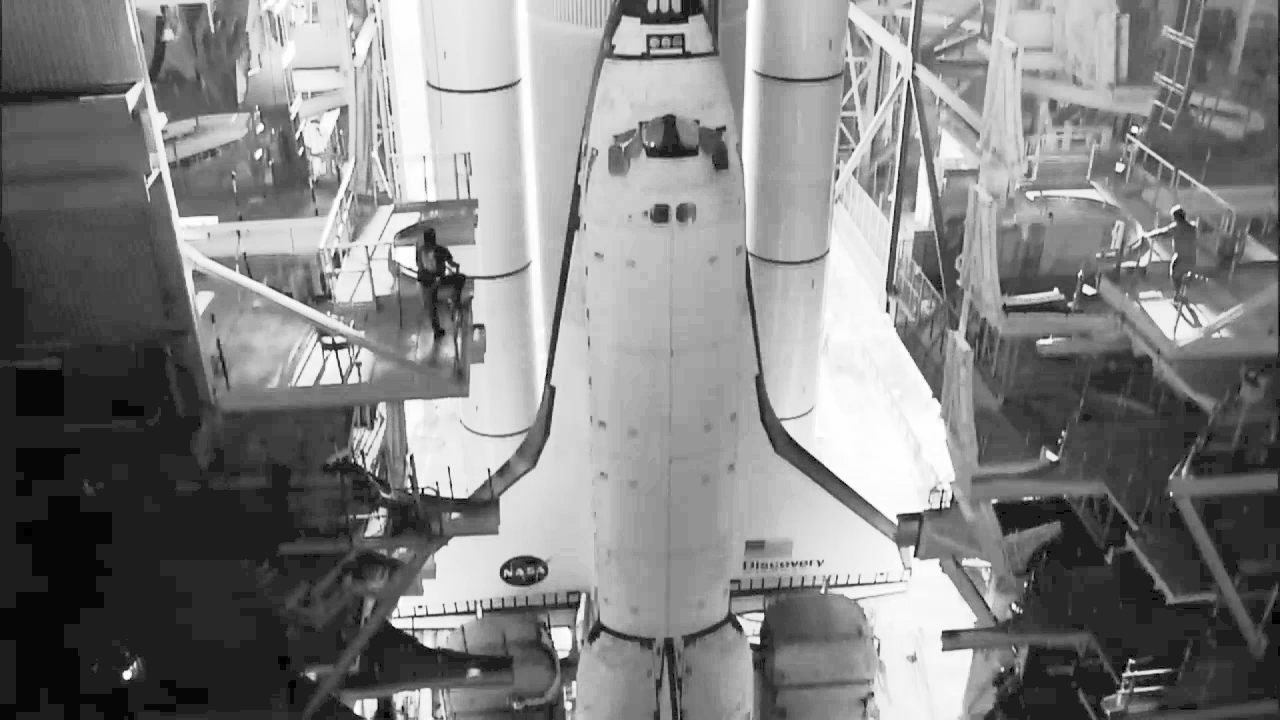

In [17]:
img_eq

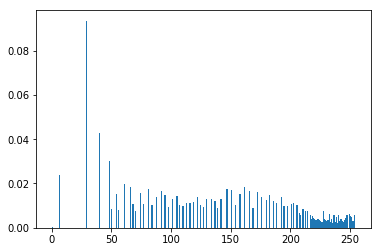

In [18]:
plt.hist(eq_int.ravel(), bins=256, density=True);

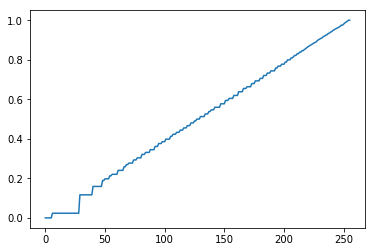

In [19]:
cdf, nbins = exposure.cumulative_distribution(eq_int)
plt.plot(cdf)

In [20]:
def plot_img_hist(image, axes, bins=256):
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    
    # Display image
    ax_img.imshow(image, cmap='gray')
    ax_img.set_axis_off()
    
    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax_hist.set_xlabel('Intensitas Piksel')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])
    
    # Display CDF
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])
    
    return ax_img, ax_hist, ax_cdf

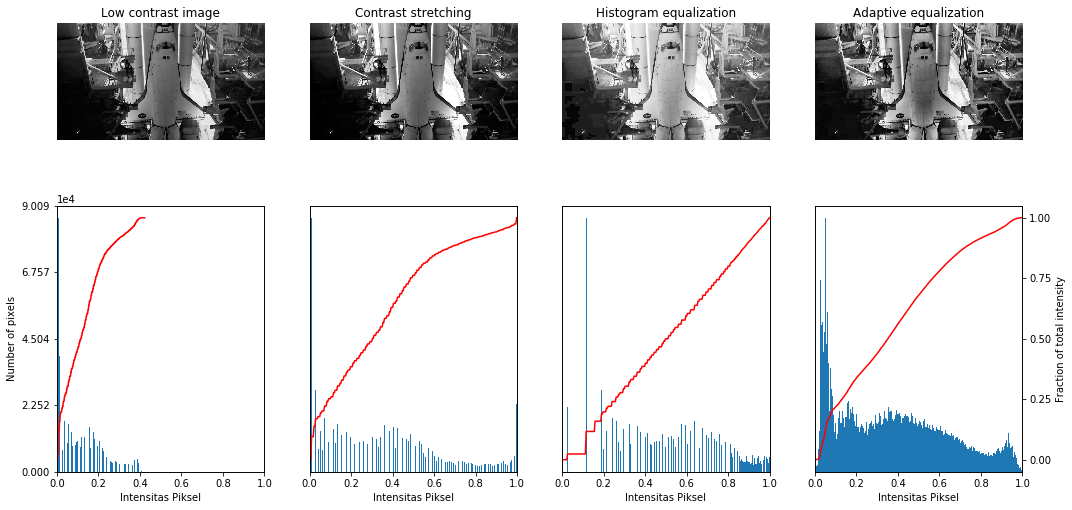

In [21]:
# Contrast Stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.02)

# Display results
fig = plt.figure(figsize=(15, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0,0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, i+1, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_hist(img, axes[:,0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

fig.tight_layout()
plt.show()